In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

In [ ]:
# df = pd.read_csv('/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv')

In [ ]:
# for local run
df = pd.read_csv('data/weatherAUS.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

#### Before splitting the data into train, validation, and test sets, I will create new features from the date column

In [ ]:
df['month'] = pd.to_datetime(df['Date']).dt.month
df['day_of_month'] = pd.to_datetime(df['Date']).dt.day
df['day_of_year'] = pd.to_datetime(df['Date']).dt.dayofyear
df['quarter'] = pd.to_datetime(df['Date']).dt.quarter
# Cyclic transformation for month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
# Cyclic transformation for day of year
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

In [ ]:
# Now we can drop the original column Date because it will not hold any valuable info for a model
df = df.drop(columns='Date')

In [ ]:
# Checking missing values
df.isnull().sum()

Location               0
MinTemp             1485
MaxTemp             1261
Rainfall            3261
Evaporation        62790
Sunshine           69835
WindGustDir        10326
WindGustSpeed      10263
WindDir9am         10566
WindDir3pm          4228
WindSpeed9am        1767
WindSpeed3pm        3062
Humidity9am         2654
Humidity3pm         4507
Pressure9am        15065
Pressure3pm        15028
Cloud9am           55888
Cloud3pm           59358
Temp9am             1767
Temp3pm             3609
RainToday           3261
RainTomorrow        3267
month                  0
day_of_month           0
day_of_year            0
quarter                0
month_sin              0
month_cos              0
day_of_year_sin        0
day_of_year_cos        0
dtype: int64

<Axes: >

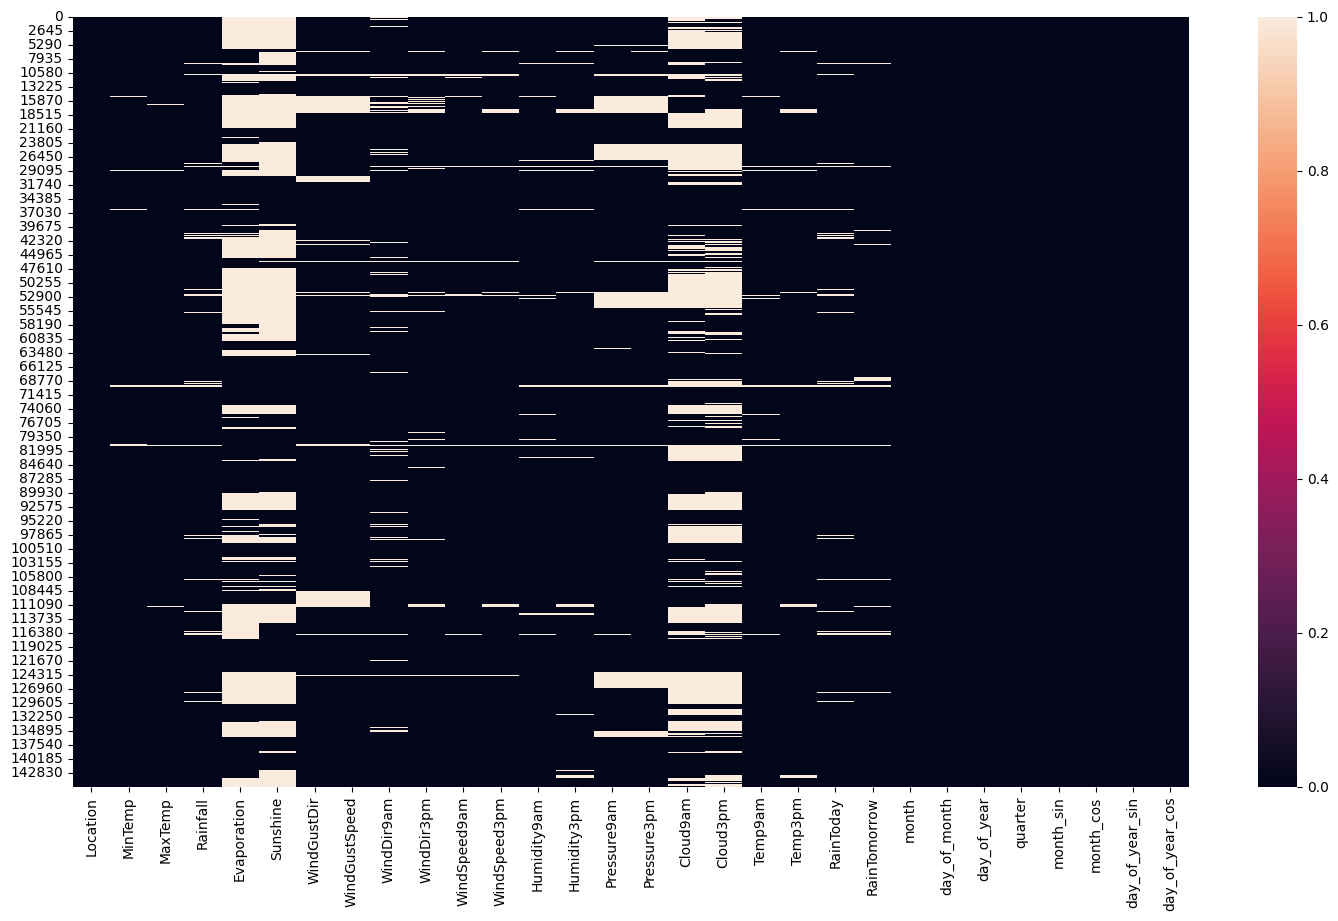

In [ ]:
# heatmap of missing values for better understanding
plt.figure(figsize=(18, 10))
sns.heatmap(df.isnull())

##### First of all we can drop rows where the target has missing values

In [ ]:
df = df.dropna(subset=['RainTomorrow'])

In [ ]:
# It also will be reasonable to drop rows with missing values in RainToday column
df = df.dropna(subset=['RainToday'])

In [ ]:
# Lets replace Yes and No values in RainToday and RainTomorrow columns
df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

In [ ]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,RainToday,RainTomorrow,month,day_of_month,day_of_year,quarter,month_sin,month_cos,day_of_year_sin,day_of_year_cos
count,140319.000000,140480.00000,140787.000000,81093.000000,73982.000000,131682.000000,139732.000000,138256.000000,139270.000000,137286.000000,...,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,1.407870e+05,1.407870e+05,140787.000000,140787.000000
mean,12.184824,23.23512,2.349974,5.472516,7.630540,39.970520,13.990496,18.631141,68.826833,51.449288,...,0.223423,0.221618,6.403482,15.714704,179.457514,2.468559,1.077311e-02,-1.638136e-02,0.018846,-0.008595
std,6.403879,7.11450,8.465173,4.189132,3.781729,13.578201,8.886210,8.798096,19.063650,20.807310,...,0.416541,0.415337,3.426583,8.798882,104.766547,1.114187,7.051801e-01,7.087621e-01,0.706892,0.707023
min,-8.500000,-4.80000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-1.000000e+00,-1.000000e+00,-0.999991,-0.999963
25%,7.600000,17.90000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,...,0.000000,0.000000,3.000000,8.000000,89.000000,1.000000,-5.000000e-01,-8.660254e-01,-0.693281,-0.720667
50%,12.000000,22.60000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,...,0.000000,0.000000,6.000000,16.000000,176.000000,2.000000,1.224647e-16,-1.836970e-16,0.060213,-0.012910
75%,16.800000,28.30000,0.800000,7.400000,10.700000,48.000000,19.000000,24.000000,83.000000,66.000000,...,0.000000,0.000000,9.000000,23.000000,270.000000,3.000000,5.000000e-01,5.000000e-01,0.717677,0.690173
max,33.900000,48.10000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,...,1.000000,1.000000,12.000000,31.000000,366.000000,4.000000,1.000000e+00,1.000000e+00,0.999991,1.000000


#### Columns Evaporation, Sunshine, cloud9am, and coud3pm contain a lot of missing values(40-50%). With such a huge proportion of missing values we can consider dropping these columns. I will try different approaches of dealing with missing values in these columns(Dropping columns, IterativeImputer, Building models for missing values prediction)

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

In [ ]:
# Check the distribution of numeric columns with missing values before imputation
num = train_df.select_dtypes(include=['number'])
missing_counts = num.isnull().sum()
columns_with_missing = missing_counts[missing_counts > 0].index.tolist()

In [ ]:
def plot_num_distribution(df, columns):
    fig, axes = plt.subplots(nrows=len(columns_with_missing), figsize=(8, len(columns_with_missing) * 3))

    for i, col in enumerate(columns_with_missing):
        sns.histplot(train_df[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')

In [ ]:
import warnings
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

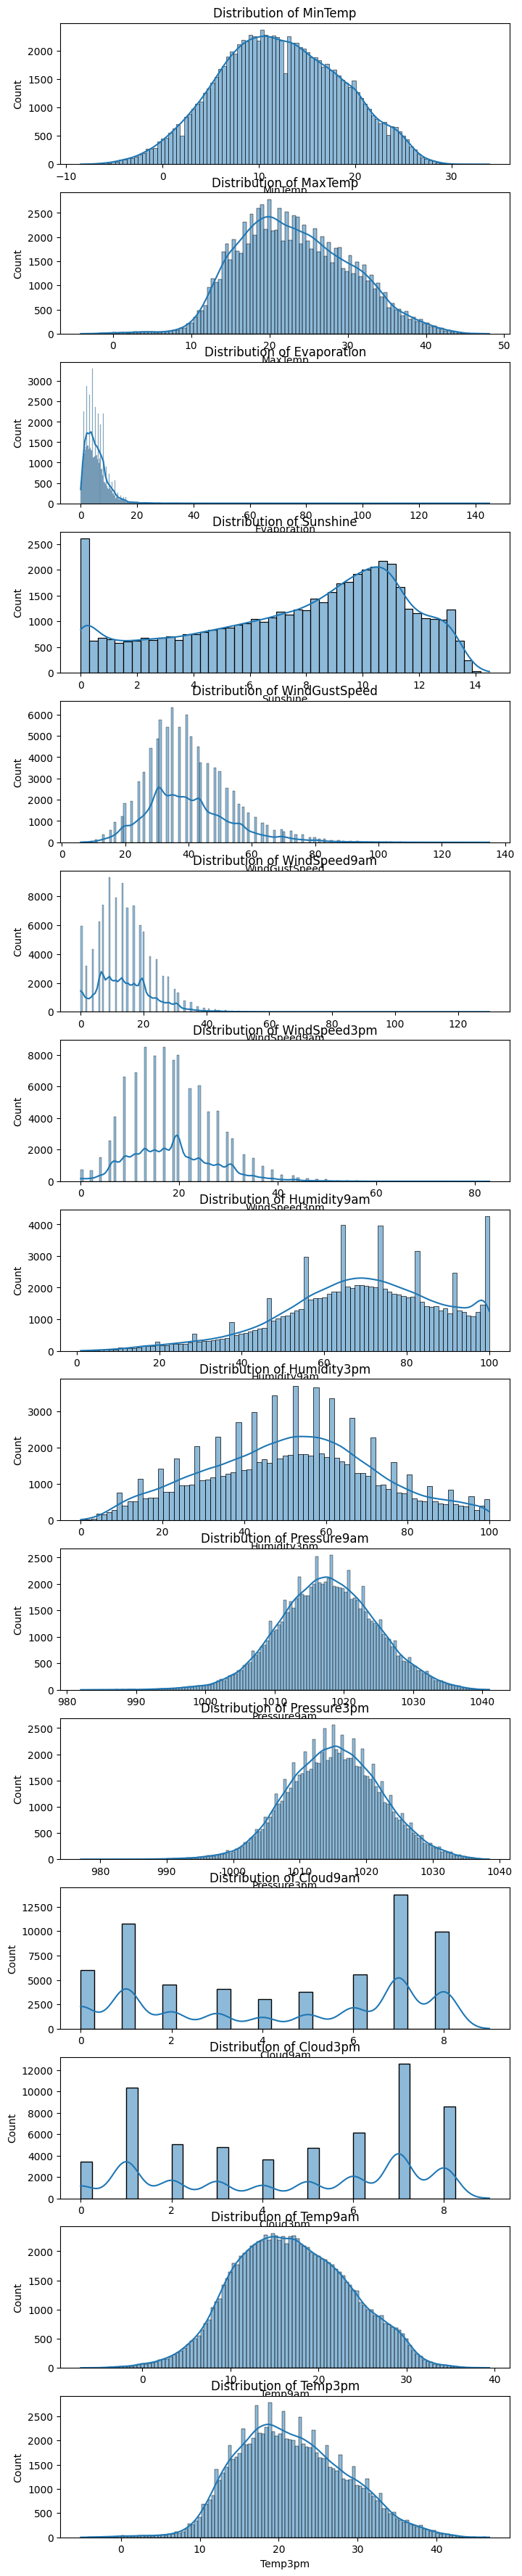

In [ ]:
plot_num_distribution(train_df, columns_with_missing)

In [ ]:
# Creating a function for handling missing values
def iter_imputer_frequent(df):

    df_1 = df.copy(deep=True)
    categorical_columns = df_1.select_dtypes(include=['object', 'category']).columns
    numerical_columns = df_1.select_dtypes(include=['number']).columns

    # handling missing values in categorical columns
    for col in categorical_columns:
        df_1[col] = df_1[col].fillna(df_1[col].mode()[0])


    # In order to speed up the process I will train the imputer on a subset
    # Select a subset for training the imputer
    subset = df_1.sample(frac=0.5, random_state=42)

    # handling missing values for numerical columns
    imputer = KNNImputer(n_neighbors=3)
    imputer.fit(subset[numerical_columns])

    # Apply the trained imputer to the full dataset
    df_1[numerical_columns] = imputer.transform(df_1[numerical_columns])

    return df_1

In [ ]:
%%time
train_df = iter_imputer_frequent(train_df)

CPU times: user 4min 48s, sys: 52 s, total: 5min 40s
Wall time: 5min 7s


In [ ]:
train_df.isnull().sum()

Location           0
MinTemp            0
MaxTemp            0
Rainfall           0
Evaporation        0
Sunshine           0
WindGustDir        0
WindGustSpeed      0
WindDir9am         0
WindDir3pm         0
WindSpeed9am       0
WindSpeed3pm       0
Humidity9am        0
Humidity3pm        0
Pressure9am        0
Pressure3pm        0
Cloud9am           0
Cloud3pm           0
Temp9am            0
Temp3pm            0
RainToday          0
RainTomorrow       0
month              0
day_of_month       0
day_of_year        0
quarter            0
month_sin          0
month_cos          0
day_of_year_sin    0
day_of_year_cos    0
dtype: int64

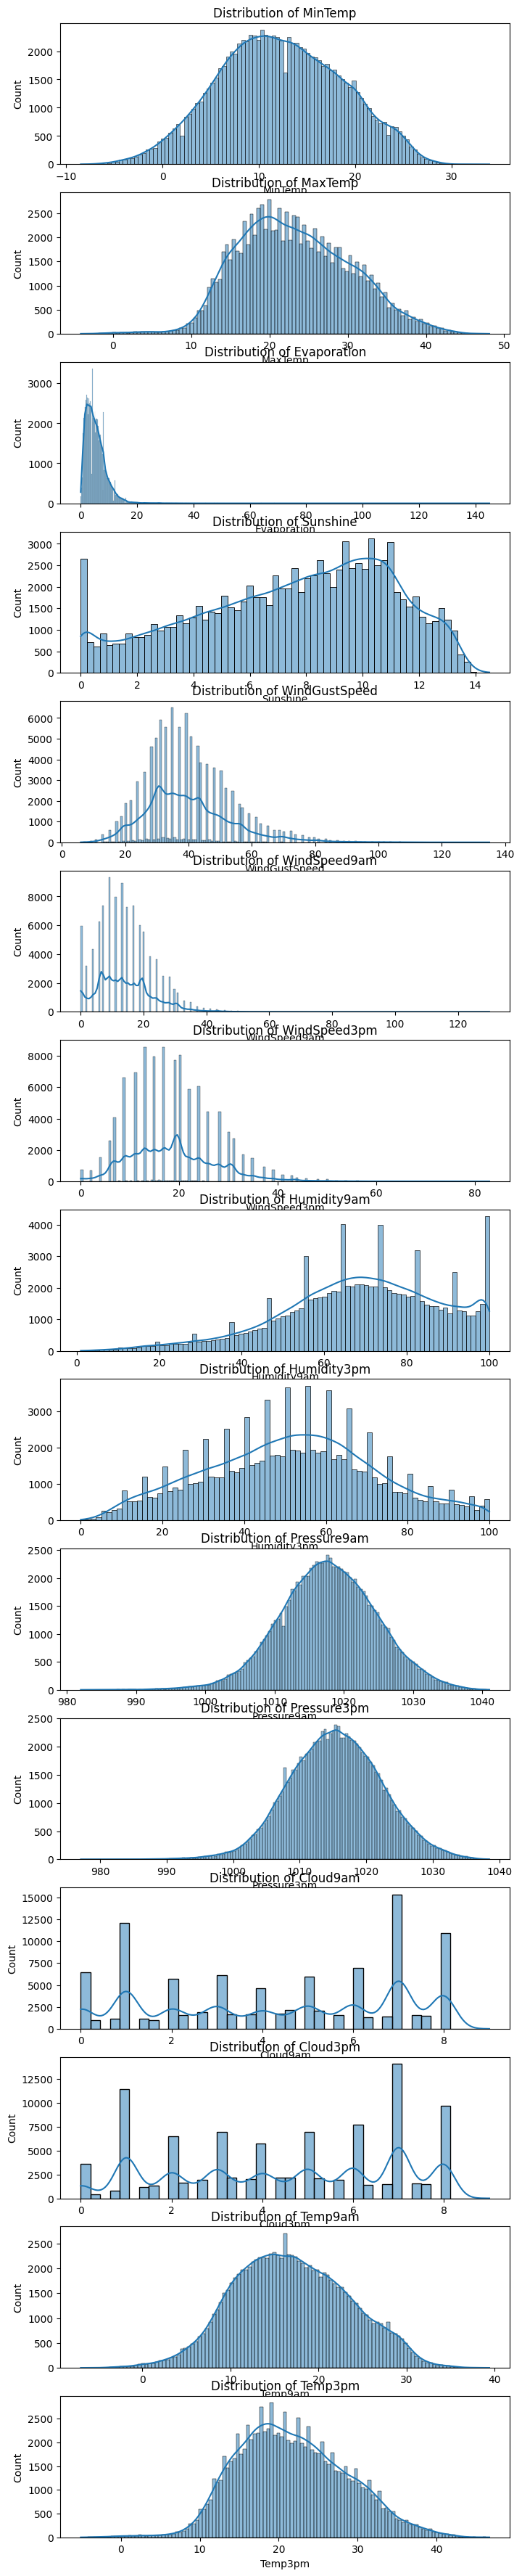

In [ ]:
# Lets check the distribution after the imputation
plot_num_distribution(train_df, columns_with_missing)

In [ ]:
train_df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,RainToday,RainTomorrow,month,day_of_month,day_of_year,quarter,month_sin,month_cos,day_of_year_sin,day_of_year_cos
count,98550.000000,98550.000000,98550.000000,98550.000000,98550.000000,98550.000000,98550.000000,98550.000000,98550.000000,98550.000000,...,98550.000000,98550.000000,98550.000000,98550.000000,98550.000000,98550.000000,9.855000e+04,9.855000e+04,98550.000000,98550.000000
mean,12.189163,23.227268,2.382032,5.249023,7.546752,39.780815,13.979012,18.609893,68.908162,51.537947,...,0.223338,0.221045,6.402121,15.726088,179.428260,2.467732,1.059763e-02,-1.637693e-02,0.019225,-0.008653
std,6.412547,7.128720,8.668974,3.825591,3.474880,13.470678,8.859779,8.745335,19.022399,20.739759,...,0.416485,0.414953,3.428678,8.803956,104.836043,1.114018,7.038773e-01,7.100609e-01,0.705338,0.708565
min,-8.500000,-4.100000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-1.000000e+00,-1.000000e+00,-0.999991,-0.999963
25%,7.600000,17.900000,0.000000,2.600000,5.066667,31.000000,7.000000,13.000000,57.000000,37.000000,...,0.000000,0.000000,3.000000,8.000000,89.000000,1.000000,-5.000000e-01,-8.660254e-01,-0.693281,-0.720667
50%,12.000000,22.600000,0.000000,4.600000,8.066667,38.666667,13.000000,19.000000,70.000000,52.000000,...,0.000000,0.000000,6.000000,16.000000,176.000000,2.000000,1.224647e-16,-1.836970e-16,0.060213,-0.012910
75%,16.800000,28.300000,0.800000,7.000000,10.300000,48.000000,19.000000,24.000000,83.000000,66.000000,...,0.000000,0.000000,9.000000,23.000000,270.000000,3.000000,5.000000e-01,5.000000e-01,0.717677,0.702527
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,83.000000,100.000000,100.000000,...,1.000000,1.000000,12.000000,31.000000,366.000000,4.000000,1.000000e+00,1.000000e+00,0.999991,1.000000


#### After applying KNNImputer the distributions of numerical features look quite similar which means the imputation worked well

#### Splitting the test dataset into validation and test sets

In [ ]:
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [ ]:
# Applying the imputation function to the validation and test sets separately to prevent leakage
val_df = iter_imputer_frequent(val_df)
test_df = iter_imputer_frequent(test_df)

In [ ]:
val_df.isnull().sum().sum()

0

In [ ]:
test_df.isnull().sum().sum()

0

In [ ]:
test_df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,RainToday,RainTomorrow,month,day_of_month,day_of_year,quarter,month_sin,month_cos,day_of_year_sin,day_of_year_cos
count,21119.000000,21119.000000,21119.000000,21119.000000,21119.000000,21119.000000,21119.000000,21119.000000,21119.000000,21119.000000,...,21119.000000,21119.000000,21119.000000,21119.000000,21119.000000,21119.000000,2.111900e+04,2.111900e+04,21119.000000,21119.000000
mean,12.110698,23.262211,2.169970,5.265085,7.622556,39.704137,13.858421,18.581451,68.754518,51.207475,...,0.218429,0.218902,6.420048,15.714191,179.957763,2.473271,9.294496e-03,-1.901244e-02,0.016894,-0.011074
std,6.385562,7.094388,7.747985,3.800535,3.464297,13.383830,8.860298,8.832557,19.115200,20.642156,...,0.413190,0.413512,3.414611,8.794270,104.407436,1.113985,7.082167e-01,7.057113e-01,0.710782,0.703156
min,-8.000000,-4.800000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-1.000000e+00,-1.000000e+00,-0.999991,-0.999963
25%,7.500000,18.000000,0.000000,2.600000,5.200000,31.000000,7.000000,13.000000,57.000000,36.000000,...,0.000000,0.000000,3.000000,8.000000,89.000000,1.000000,-5.000000e-01,-8.660254e-01,-0.705584,-0.708627
50%,11.900000,22.700000,0.000000,4.600000,8.100000,38.333333,13.000000,17.333333,70.000000,52.000000,...,0.000000,0.000000,6.000000,16.000000,176.000000,2.000000,1.224647e-16,-1.836970e-16,0.051620,-0.012910
75%,16.800000,28.300000,0.600000,7.066667,10.400000,46.333333,19.000000,24.000000,83.000000,65.000000,...,0.000000,0.000000,9.000000,23.000000,271.000000,3.000000,5.000000e-01,5.000000e-01,0.723644,0.690173
max,31.400000,46.700000,219.600000,86.200000,14.100000,122.000000,83.000000,83.000000,100.000000,100.000000,...,1.000000,1.000000,12.000000,31.000000,366.000000,4.000000,1.000000e+00,1.000000e+00,0.999991,1.000000


#### Encoding categorical variables

In [ ]:
# Checking if the Location has an imfluence on the target
location_target_means = train_df.groupby('Location')['RainTomorrow'].mean()

In [ ]:
location_target_means.sort_values(ascending=False)

Location
Portland            0.364548
Walpole             0.349485
Dartmoor            0.320437
MountGambier        0.312560
Cairns              0.309443
Albany              0.302004
NorfolkIsland       0.300726
Witchcliffe         0.297297
CoffsHarbour        0.286466
MountGinini         0.282838
NorahHead           0.276000
GoldCoast           0.268102
Darwin              0.266785
SydneyAirport       0.257598
Sydney              0.254936
Ballarat            0.250951
Williamtown         0.243667
Watsonia            0.242527
Wollongong          0.236310
Newcastle           0.233398
Melbourne           0.230251
Hobart              0.228910
Launceston          0.227615
Brisbane            0.225499
MelbourneAirport    0.218515
Sale                0.213099
Adelaide            0.211521
Perth               0.204515
Albury              0.202148
BadgerysCreek       0.199316
Nuriootpa           0.198466
Richmond            0.195770
PerthAirport        0.191049
Penrith             0.190268
Tugge

#### The mean target values vary significantly (from 0.06 to 0.37), indicating that location is predictive of the target

In [ ]:
# For the Location I will use target encoding
train_df['Location_encoded'] = train_df['Location'].map(location_target_means)

In [ ]:
# Apply the same mapping to val and test sets
val_df['Location_encoded'] = val_df['Location'].map(location_target_means)
test_df['Location_encoded'] = test_df['Location'].map(location_target_means)

In [ ]:
# Checking for missing values in val and test sets in case of certain location didnt exist in train data
val_df.isnull().sum().sum(), test_df.isnull().sum().sum()

(0, 0)

In [ ]:
# Dropping the original, Location column, since it is already encoded
train_df = train_df.drop(columns='Location')
val_df = val_df.drop(columns='Location')
test_df = test_df.drop(columns='Location')

#### Encoding wind direction columns

In [ ]:
# Function for Label encoding
def label_encoding(df):
    df_1 = df.copy()
    # find categorical columns
    cat = df_1.select_dtypes(exclude=[np.number])

    # Define the encoder
    le = LabelEncoder()

    for col in cat.columns:
        df_1[col + '_LE'] = le.fit_transform(df_1[col])
        df_1.drop(columns=[col], inplace=True)

    return df_1

In [ ]:
train_df = label_encoding(train_df)

In [ ]:
# Apply this function to val and test sets
val_df = label_encoding(val_df)
test_df = label_encoding(test_df)

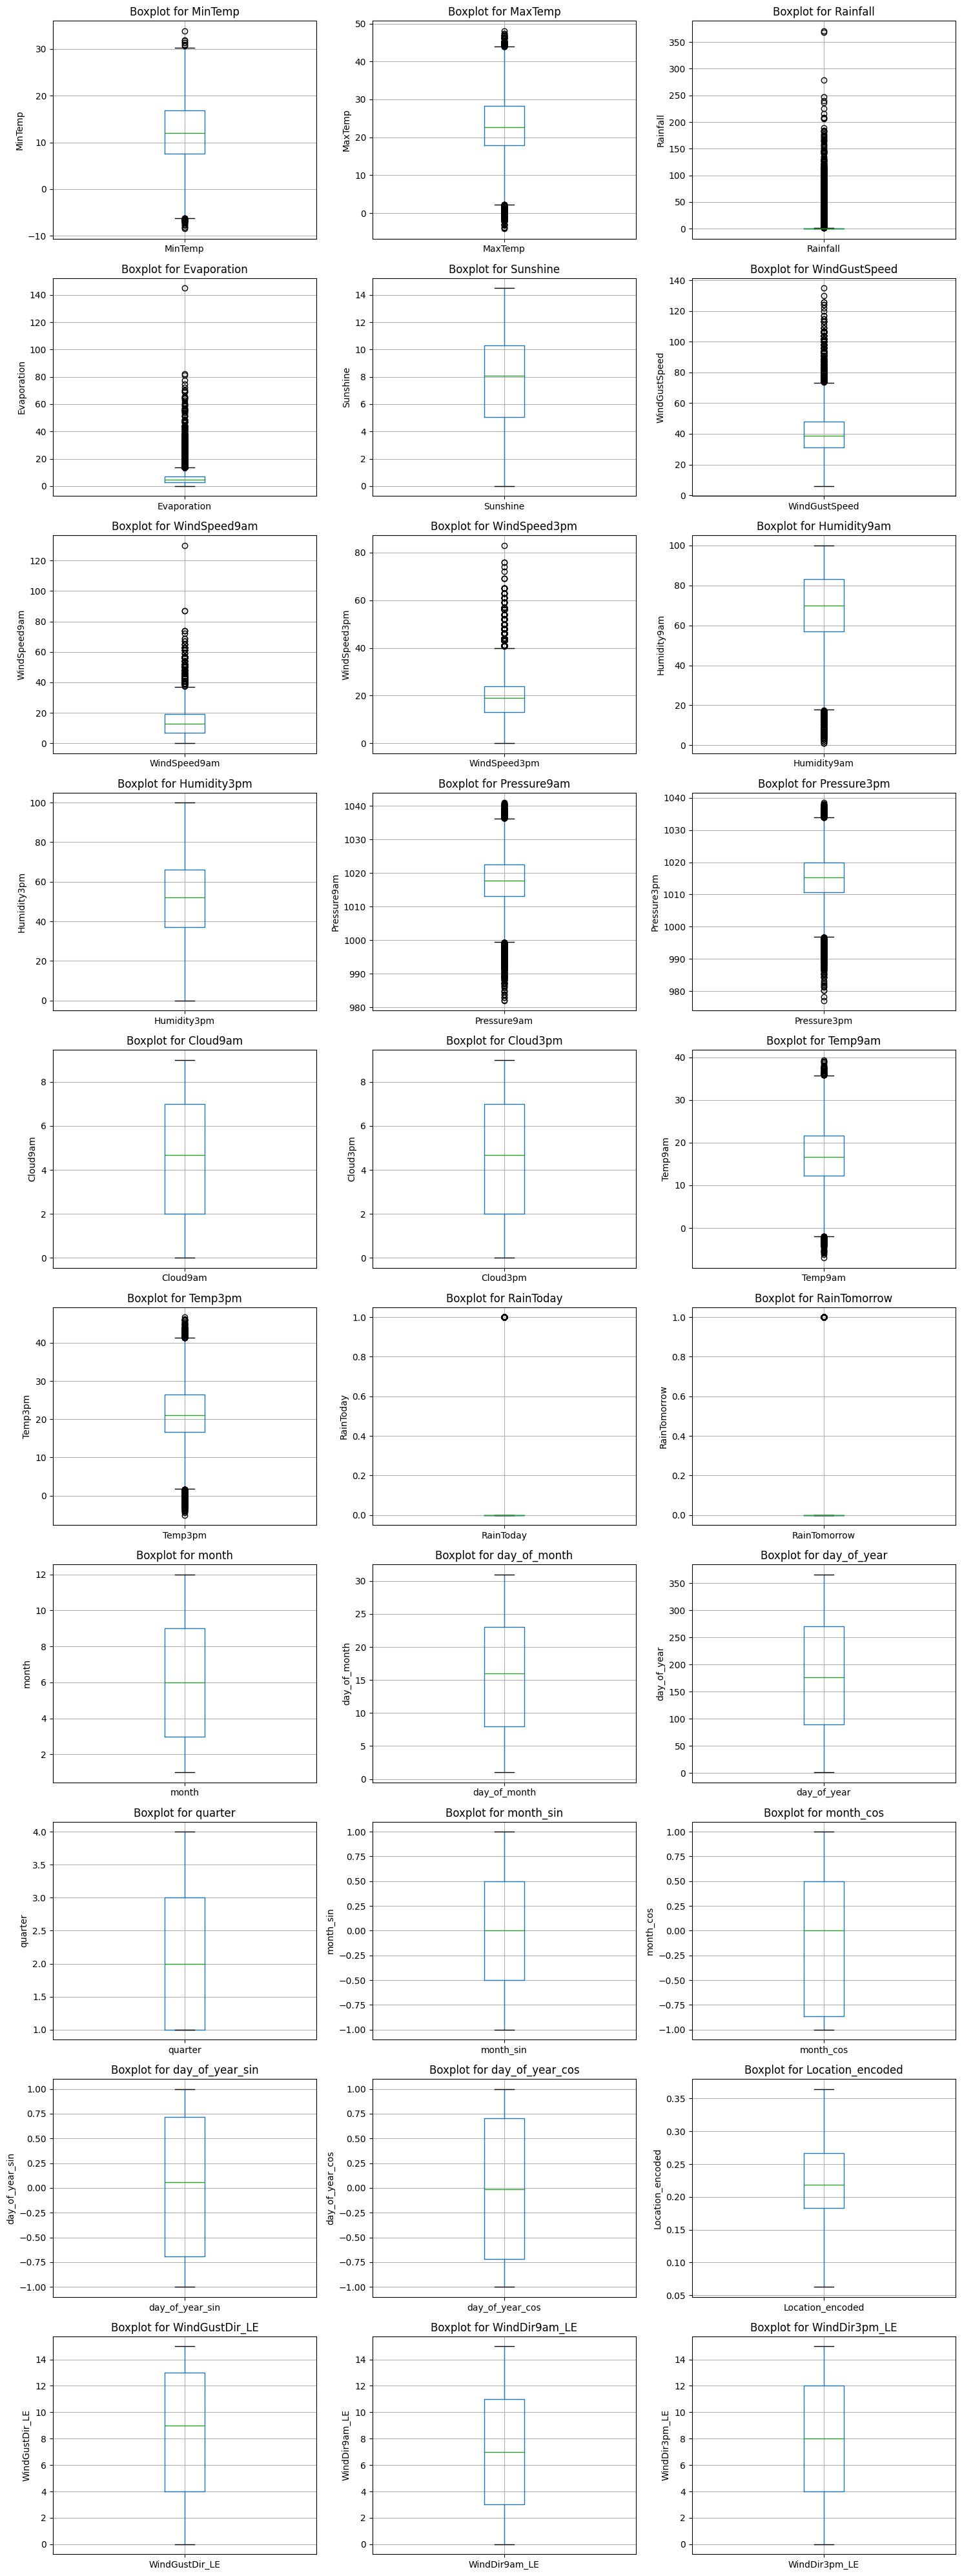

In [ ]:
features = list(train_df.columns)
num_features = len(features)

# Calculate the total number of rows needed
num_rows = int(np.ceil(num_features / 3))

# Create subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 4))

# Flatten axes for easy iteration
axes = axes.flatten()

# Loop through features and plot boxplots
for i, feature in enumerate(features):
    train_df.boxplot(column=[feature], ax=axes[i])
    axes[i].set_title(f"Boxplot for {feature}")
    axes[i].set_ylabel(feature)

# Hide unused subplots if the number of features isn't a multiple of 3
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


#### From the box plots above it is noticeable that columns Rainfall, Evaporation, Wind columns contain outliers. I will deal with it using IQR method

In [ ]:
col_with_outliers = ['Rainfall', 'Evaporation', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']

In [ ]:
# define a function for removing outloers
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # I will use 3 IQR instead of standard 1.5 to deal with only extreme outliers
        lower_fence = Q1 - (IQR * 3)
        upper_fence = Q3 + (IQR * 3)

        # Filter out rows with outliers
        df = df[(df[col] >= lower_fence) & (df[col] <= upper_fence)]

    return df

In [ ]:
train_df.shape

(98550, 30)

In [ ]:
train_df_cleaned = remove_outliers_iqr(train_df, col_with_outliers)

In [ ]:
train_df_cleaned.shape

(83598, 30)

In [ ]:
train_df_cleaned.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,day_of_year,quarter,month_sin,month_cos,day_of_year_sin,day_of_year_cos,Location_encoded,WindGustDir_LE,WindDir9am_LE,WindDir3pm_LE
count,83598.000000,83598.000000,83598.000000,83598.000000,83598.000000,83598.000000,83598.000000,83598.000000,83598.000000,83598.000000,...,83598.000000,83598.000000,8.359800e+04,8.359800e+04,83598.000000,83598.000000,83598.000000,83598.000000,83598.000000,83598.000000
mean,11.962432,23.668484,0.254016,5.317269,7.971048,38.759899,13.546771,18.285848,66.690503,48.844546,...,179.297316,2.468193,1.137297e-02,-1.233428e-02,0.018844,-0.004379,0.218100,7.857401,6.771526,7.604357
std,6.457867,7.089011,0.623368,3.334904,3.320086,12.712902,8.555995,8.492108,18.796616,19.906550,...,105.031086,1.116346,7.056859e-01,7.083346e-01,0.708146,0.705809,0.066934,4.706264,4.490032,4.550560
min,-8.500000,-4.100000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,1.000000,-1.000000e+00,-1.000000e+00,-0.999991,-0.999963,0.062648,0.000000,0.000000,0.000000
25%,7.300000,18.400000,0.000000,2.733333,5.733333,30.000000,7.000000,13.000000,55.000000,34.000000,...,88.000000,1.000000,-5.000000e-01,-8.660254e-01,-0.699458,-0.708627,0.179097,4.000000,3.000000,4.000000
50%,11.800000,23.100000,0.000000,4.800000,8.500000,37.000000,13.000000,17.000000,68.000000,49.000000,...,176.000000,2.000000,1.224647e-16,-1.836970e-16,0.060213,0.004304,0.218515,8.000000,6.000000,8.000000
75%,16.600000,28.700000,0.100000,7.200000,10.533333,46.000000,19.000000,24.000000,80.000000,62.000000,...,270.000000,3.000000,5.000000e-01,5.000000e-01,0.723644,0.690173,0.266785,12.000000,10.000000,11.000000
max,33.900000,47.300000,3.200000,20.600000,14.500000,94.000000,54.000000,57.000000,100.000000,100.000000,...,366.000000,4.000000,1.000000e+00,1.000000e+00,0.999991,1.000000,0.364548,15.000000,15.000000,15.000000


#### Also, from the describe method it can be seen that humidity min values are 0. Which can not be true for real world scenarios. I assume that values lower than 5 can be eliminated.

In [ ]:
train_df_cleaned = train_df_cleaned[train_df_cleaned['Humidity9am'] >= 5]
train_df_cleaned = train_df_cleaned[train_df_cleaned['Humidity3pm'] >= 5]

#### Repeat the same steps for val and test sets

In [ ]:
val_df_cleaned = remove_outliers_iqr(val_df, col_with_outliers)

In [ ]:
val_df_cleaned.shape

(17837, 30)

In [ ]:
test_df_cleaned = remove_outliers_iqr(test_df, col_with_outliers)

In [ ]:
test_df_cleaned.shape

(17581, 30)

In [ ]:
val_df_cleaned = val_df_cleaned[val_df_cleaned['Humidity9am'] >= 5]
val_df_cleaned = val_df_cleaned[val_df_cleaned['Humidity3pm'] >= 5]

In [ ]:
test_df_cleaned = test_df_cleaned[test_df_cleaned['Humidity9am'] >= 5]
test_df_cleaned = test_df_cleaned[test_df_cleaned['Humidity3pm'] >= 5]

In [ ]:
# Check the distribution of the target
train_df['RainTomorrow'].value_counts()/train_df['RainTomorrow'].value_counts().sum()

RainTomorrow
0.0    0.778955
1.0    0.221045
Name: count, dtype: float64

#### The train dataset is quite unbalanced. I will use ADASYN method combined with undersampling to balance the distribution

In [ ]:
# importing required libraries
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

In [ ]:
# Increasing the number of samples in the minority class to 50% of the majority class size
oversampling = ADASYN(sampling_strategy=0.6, random_state=42)

# Reducing the number of samples in the majority class
undersampling = RandomUnderSampler(sampling_strategy=0.8, random_state=42)

In [ ]:
# Creating a pipeline
pipe = Pipeline([('ADASYN', oversampling), ('undersampling', undersampling)])

In [ ]:
X_balanced = train_df_cleaned.drop(columns=['RainTomorrow'])
y_balanced = train_df_cleaned['RainTomorrow']

In [ ]:
X_balanced, y_balanced = pipe.fit_resample(X_balanced, y_balanced)

In [ ]:
# Checking the distribution after over and undersampling
counter = Counter(y_balanced)
print(counter)

Counter({0.0: 52343, 1.0: 41875})


#### Now, our train dataset is quite balanced

#### Lets compare the model performances on two datasets

#### Building a base model and train it on original dataset

In [ ]:
X_train = train_df_cleaned.drop(columns=['RainTomorrow'])
y_train = train_df_cleaned['RainTomorrow']

In [ ]:
model_xg = XGBClassifier()

In [ ]:
# I will use stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Checking the porformance on original unbalanced data
scores_orig = cross_val_score(model_xg, X_train, y_train, cv=cv, scoring='roc_auc')

In [ ]:
scores_orig.mean()

0.8759783094923511

In [ ]:
# Now lets check the porformance on balanced data
scores = cross_val_score(model_xg, X_balanced, y_balanced, cv=cv, scoring='roc_auc')

In [ ]:
scores

array([0.95780677, 0.9585532 , 0.95629261, 0.95669758, 0.9554608 ])

#### We can see a significant improvement from 0.87 to 0.95. That might be because the model overfitts

#### Now, lets evaluate the model on unseen, validatioin data to see if there is an overfitting

In [ ]:
X_val = val_df_cleaned.drop(columns=['RainTomorrow'])
y_val = val_df_cleaned['RainTomorrow']

In [ ]:
model_xg.fit(X_balanced, y_balanced)
pred = model_xg.predict_proba(X_val)[:, 1]
score = roc_auc_score(y_val, pred)


In [ ]:
score

0.8726759048219969

#### Since there is no improvements the model overfits

#### Now, lets train the model on the original, unbalanced dataset and then evaluate it on unseen, validation set

In [ ]:
model_xg.fit(X_train, y_train)
pred_1 = model_xg.predict_proba(X_val)[:, 1]
score = roc_auc_score(y_val, pred_1)

In [ ]:
score

0.8767637286841131

#### Comparing the results of the model trained on unbalanced and balanced sets, we got no improvements. The model trained on balanced set overfits the data and not generalize well. That means that model seems to learn well from the original imbalanced structure, and that the original distribution is already providing useful patterns

### Feature engineering

In [ ]:
df_fe = train_df_cleaned.copy()

In [ ]:
# Creating a function for testing new features

def test_new_feature(df, feature_name, feature_values):
    """
    Adds a new feature to the dataset and evaluates the model's performance.
    """
    df[feature_name] = feature_values  # Add new feature

    # Split into train/test sets
    X_train_new = df.drop(columns=['RainTomorrow'])  # Exclude target variable
    y_train_new = df['RainTomorrow']

    # Evaluate model with new feature
    cv_scores = cross_val_score(model_xg, X_train_new, y_train_new, cv=5, scoring='roc_auc')

    return cv_scores.mean()


In [ ]:
candidate_features = {
    'Humidity_cloud_prod3pm': lambda df: df['Humidity3pm'] * df['Cloud3pm'],
    'Humidity_cloud_prod9am': lambda df: df['Humidity9am'] * df['Cloud9am'],
    'total_cloud': lambda df: df['Cloud9am'] + df['Cloud3pm'],
    'total_humidity': lambda df: df['Humidity9am'] + df['Humidity3pm'],
    'avg_humidity_daily': lambda df: (df['Humidity9am'] + df['Humidity3pm']) / 2,
    'sun_cloud_ratio': lambda df: (df['Cloud9am'] + df['Cloud3pm']) / (df['Sunshine'] + 1),
    'evap_humidity_ratio': lambda df: df['Evaporation'] / (((df['Humidity9am'] + df['Humidity3pm']) / 2) + 1),
    'pressure_temp_ratio': lambda df: ((df['Temp9am'] + df['Temp3pm']) / 2) / ((df['Pressure9am'] + df['Pressure3pm']) / 2),
    'avg_rainfall_monthly': lambda df: df.groupby('month')['Rainfall'].transform('mean') if 'month' in df.columns else None,
    'wind_gust_diff': lambda df: df['WindGustSpeed'] - (df['WindSpeed9am'] + df['WindSpeed3pm']) / 2,
    'total_moisture': lambda df: df['Evaporation'] + df['Rainfall'],
    'rainfall_rolling_avg': lambda df: df['Rainfall'].rolling(window=7, min_periods=1).mean(),
    'evaporation_rolling_avg': lambda df: df['Evaporation'].rolling(window=7, min_periods=1).mean(),
    'sunshine_rolling_avg': lambda df: df['Sunshine'].rolling(window=7, min_periods=1).mean()
}


In [ ]:
best_features = []

In [ ]:
cv_scores_baseline = scores_orig.mean()

In [ ]:
for feature_name, feature_func in candidate_features.items():
    train_df_copy = df_fe.copy()  # Ensure each feature is tested independently
    train_df_copy[feature_name] = feature_func(train_df)  # Apply transformation

    # Evaluate model with new feature
    auc_score = test_new_feature(train_df_copy, feature_name, train_df_copy[feature_name])

    print(f'Feature: {feature_name} - AUC: {auc_score:.4f}')

    # Keep only features that improve AUC
    if auc_score > cv_scores_baseline:
        best_features.append(feature_name)

Feature: Humidity_cloud_prod3pm - AUC: 0.8755
Feature: Humidity_cloud_prod9am - AUC: 0.8771
Feature: total_cloud - AUC: 0.8760
Feature: total_humidity - AUC: 0.8775
Feature: avg_humidity_daily - AUC: 0.8775
Feature: sun_cloud_ratio - AUC: 0.8765
Feature: evap_humidity_ratio - AUC: 0.8772
Feature: pressure_temp_ratio - AUC: 0.8765
Feature: avg_rainfall_monthly - AUC: 0.8768
Feature: wind_gust_diff - AUC: 0.8762
Feature: total_moisture - AUC: 0.8767
Feature: rainfall_rolling_avg - AUC: 0.8763
Feature: evaporation_rolling_avg - AUC: 0.8756
Feature: sunshine_rolling_avg - AUC: 0.8752


In [ ]:
best_features

['Humidity_cloud_prod9am',
 'total_cloud',
 'total_humidity',
 'avg_humidity_daily',
 'sun_cloud_ratio',
 'evap_humidity_ratio',
 'pressure_temp_ratio',
 'avg_rainfall_monthly',
 'wind_gust_diff',
 'total_moisture',
 'rainfall_rolling_avg']

#### I have a list of features that individually improved model performance. Lets add them to the dataset and test the model on all features

In [ ]:
# Function for adding new features
def feature_creation(df_1):
    df=df_1.copy()

    # product of hunidity and cloud at 9am
    df['Humidity_cloud_prod9am'] = df['Humidity9am'] * df['Cloud9am']

    # Total sum of clouds
    df['total_cloud'] = df['Cloud9am'] + df['Cloud3pm']

    # Total sum of humidity
    df['total_humidity'] = df['Humidity9am'] + df['Humidity3pm']

    # AVG humidity per day
    df['avg_humidity_daily'] = (df['Humidity9am'] + df['Humidity3pm']) / 2

    # The sum of cloud at 3 PM and at 9 AM in relation to sunshine
    # adding 1 to avoid division by 0
    df['sun_cloud_ratio'] = (df['Cloud9am'] + df['Cloud3pm']) / (df['Sunshine'] + 1)

    # evaporation humidity ratio
    df['evap_humidity_ratio'] = df['Evaporation'] / (((df['Humidity9am'] + df['Humidity3pm']) / 2) + 1)

    # pressure-to-temperature ratio
    df['pressure_temp_ratio'] = ((df['Temp9am']+df['Temp3pm'])/2) / ((df['Pressure9am']+df['Pressure3pm'])/2)

    # avg rainfall per months
    df['avg_rainfall_monthly'] = df.groupby('month')['Rainfall'].transform('mean')

    # difference between gust and daily wind speed
    df['wind_gust_diff'] = df['WindGustSpeed'] - (df['WindSpeed9am'] + df['WindSpeed3pm']) / 2

    # Sum of evaporation and rainfall(moisture in atmosphire)
    df['total_moisture'] = df['Evaporation'] + df['Rainfall']

    # rainfall rolling avg
    df['rainfall_rolling_avg'] = df['Rainfall'].rolling(window=7, min_periods=1).mean()

    return df

In [ ]:
# Using this function to add new features to train_df_cleaned
train_df_cleaned = feature_creation(train_df_cleaned)

In [ ]:
X_train = train_df_cleaned.drop(columns=['RainTomorrow'])
y_train = train_df_cleaned['RainTomorrow']

In [ ]:
# Cross-validation with new features
cv_scores_fe = cross_val_score(model_xg, X_train, y_train, cv=5, scoring='roc_auc')

In [ ]:
cv_scores_fe.mean()

0.8747599105008357

In [ ]:
# adding new features to validation set
val_df_cleaned = feature_creation(val_df_cleaned)

In [ ]:
X_val = val_df_cleaned.drop(columns=['RainTomorrow'])
y_val = val_df_cleaned['RainTomorrow']

In [ ]:
# fit the model to the training set
model_xg.fit(X_train, y_train)
pred_1 = model_xg.predict_proba(X_val)[:, 1]
score = roc_auc_score(y_val, pred_1)

In [ ]:
score

0.8784717375569796

#### After adding new features the score alightly increased from 0.8767 to 0.8784

In [ ]:
# lets add new features to test set
test_df_cleaned = feature_creation(test_df_cleaned)

### Tuning hyperparameters

In [ ]:
tuned_model = xgb.XGBClassifier()

In [ ]:
# Firstly, I will perform a grid search in 2 stages for different params
param_grid_stage1 = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [3, 5, 7]
}

In [ ]:
grid_search_stage1 = GridSearchCV(
    estimator=tuned_model, param_grid=param_grid_stage1,
    scoring='roc_auc', cv=5, n_jobs=-1
)

In [ ]:
%%time
grid_search_stage1.fit(X_train, y_train)

CPU times: user 37.7 s, sys: 2.2 s, total: 39.9 s
Wall time: 10min 17s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 300, 500, 700]},
             scoring='roc_auc')

In [ ]:
print("Best params from Stage 1:", grid_search_stage1.best_params_)

Best params from Stage 1: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 700}


In [ ]:
# Extract best params from Stage 1
best_stage1_params = grid_search_stage1.best_params_

In [ ]:
param_grid_stage2 = {
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5, 1.0]
}

In [ ]:
# Use best params from Stage 1 as fixed values in Stage 2
grid_search_stage2 = GridSearchCV(
    estimator=xgb.XGBClassifier(**best_stage1_params),
    param_grid=param_grid_stage2,
    scoring='roc_auc', cv=5, n_jobs=-1
)

In [ ]:
grid_search_stage2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.05,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=7,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=700,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 0.1, 0.5, 1.0],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='roc_auc')

In [ ]:
print("Final optimized hyperparameters:", grid_search_stage2.best_params_)

Final optimized hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'subsample': 0.8}


#### Train the model with chosen parameters

In [ ]:
final_model = XGBClassifier(learning_rate=0.05, max_depth=7, n_estimators=700,
                           colsample_bytree=1.0, gamma=0.1, subsample=0.8)

In [ ]:
final_model.fit(X_train, y_train)
pred = final_model.predict_proba(X_val)[:, 1]
score = roc_auc_score(y_val, pred)

In [ ]:
score

0.8892921206593066

#### We got an improvement from 0.8794 to 0.8893

##### Lets make a final prediction on test set

In [ ]:
test_df_cleaned

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,total_cloud,total_humidity,avg_humidity_daily,sun_cloud_ratio,evap_humidity_ratio,pressure_temp_ratio,avg_rainfall_monthly,wind_gust_diff,total_moisture,rainfall_rolling_avg
91295,21.5,28.1,0.0,9.000000,11.700000,35.000000,19.0,26.0,60.0,63.0,...,4.000000,123.0,61.5,0.314961,0.144000,0.026706,0.153969,12.500000,9.000000,0.000000
72501,24.8,41.1,0.0,12.000000,13.100000,33.000000,19.0,13.0,33.0,16.0,...,4.000000,49.0,24.5,0.283688,0.470588,0.035563,0.150442,17.000000,12.000000,0.000000
110855,9.0,21.0,0.0,2.400000,5.700000,28.333333,4.0,9.0,75.0,42.0,...,12.000000,117.0,58.5,1.791045,0.040336,0.015139,0.237951,21.833333,2.400000,0.000000
33702,9.8,19.4,0.0,4.800000,8.400000,52.000000,13.0,35.0,41.0,27.0,...,2.000000,68.0,34.0,0.212766,0.137143,0.017032,0.242022,28.000000,4.800000,0.000000
8920,25.9,39.8,0.0,9.333333,11.266667,41.000000,30.0,15.0,52.0,27.0,...,5.333333,79.0,39.5,0.434783,0.230453,0.032355,0.160498,18.500000,9.333333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141511,23.8,33.9,0.0,6.400000,10.800000,31.000000,13.0,15.0,67.0,59.0,...,9.000000,126.0,63.0,0.762712,0.100000,0.029467,0.177469,17.000000,6.400000,0.085714
141942,22.6,33.0,0.0,9.400000,10.800000,54.000000,30.0,22.0,52.0,33.0,...,1.000000,85.0,42.5,0.084746,0.216092,0.028493,0.237951,28.000000,9.400000,0.057143
28835,14.3,24.3,0.2,10.200000,9.933333,56.000000,22.0,41.0,34.0,17.0,...,7.666667,51.0,25.5,0.701220,0.384906,0.020978,0.178817,24.500000,10.400000,0.085714
61818,3.8,13.8,0.2,5.000000,9.500000,56.000000,33.0,30.0,62.0,70.0,...,6.000000,132.0,66.0,0.571429,0.074627,0.009205,0.192280,24.500000,5.200000,0.114286


In [ ]:
X_test = test_df_cleaned.drop(columns=['RainTomorrow'])
y_test = test_df_cleaned['RainTomorrow']

In [ ]:
pred_final = final_model.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, pred_final)

In [ ]:
score

0.883987205910525

In [ ]:
X_test = X_test.reset_index()

In [ ]:
final_prediction = pd.DataFrame()
final_prediction['index'] = X_test['index']
final_prediction['RainTomorrow'] = pred_final
final_prediction.to_csv('output.csv', index=False)